In [1]:
### Configs ###
TASK = "multi_tasks"  # choose from 'pose_single', 'pose_multi', 'depth', 'multi_tasks'
MODEL = "resnet50"  # enter model name
N_EPOCHS = 128  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    16  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-4  # enter learning rate
AUGMENTATION = True
CONTINUE_TRAINING = False
MULTI_TASKS_POSE_TYPE = "single"  # "single" or "multi"
MULTI_TASKS_REGRESSION_LOSS_WEIGHT = 8  # Weight for regression loss in multi-tasks
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from microrobot_dl.task import Task
from microrobot_dl.inference import evaluate_model, run_inference
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
num_outputs = 1
mode = None
multi_label = False

if TASK == Task.pose_single:
    mode = "pose"
    multi_label = False
elif TASK == Task.pose_multi:
    mode = "pose"
    multi_label = True
elif TASK == Task.depth:
    mode = "depth"
elif TASK == Task.multi_tasks:
    mode = None
    multi_label = MULTI_TASKS_POSE_TYPE == "multi"
else:
    raise ValueError(f"Task {TASK} not supported yet.")

dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset",
    mode=mode,
    multi_label=multi_label,
    multi_task=(TASK == Task.multi_tasks),
    transform=None,
)

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    num_classes_p = len(dataset.idx_to_label_p)
    num_classes_r = len(dataset.idx_to_label_r)
    num_outputs = num_classes_p + num_classes_r
    print(f"Pose Multi: P classes={num_classes_p}, R classes={num_classes_r}")
elif TASK == Task.pose_single or (TASK == Task.multi_tasks and not multi_label):
    num_outputs = len(dataset.idx_to_label)

if TASK == Task.multi_tasks:
    num_outputs += 1  # Add depth output
    print(f"Multi Task: Pose outputs + 1 Depth output = {num_outputs}")

print(f"mode: {mode}, num_outputs: {num_outputs}")
print(f"Total samples: {len(dataset)}")

Multi Task: Pose outputs + 1 Depth output = 41
mode: None, num_outputs: 41
Total samples: 2000


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    if TASK in [Task.pose_single, Task.pose_multi]:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.depth:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15.0),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.multi_tasks:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_outputs=num_outputs, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
if TASK in [Task.pose_single, Task.pose_multi]:
    criterion = nn.CrossEntropyLoss()
elif TASK == Task.depth:
    criterion = nn.MSELoss()
elif TASK == Task.multi_tasks:
    criterion_pose = nn.CrossEntropyLoss()
    criterion_depth = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
suffix = ""
if AUGMENTATION:
    suffix += "_augmented"

if multi_label and TASK == Task.multi_tasks:
    suffix += "_multi_label"

MODEL_NAME = f"{MODEL}_{TASK}{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # Stores Accuracy for pose, RMSE for depth
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    running_mse = 0.0
    correct = 0
    total = 0

    for outputs, labels in tqdm(
        run_inference(model, train_loader, device, TASK, training=True),
        total=len(train_loader),
    ):
        optimizer.zero_grad()

        if TASK == Task.multi_tasks:
            pose_labels, depth_labels = labels
        else:
            # labels is already a tensor on device
            pass

        if TASK == Task.pose_multi:
            # labels: [batch, 2] (p, r)
            label_p = labels[:, 0]
            label_r = labels[:, 1]

            # Split output
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]

            loss = criterion(out_p, label_p) + criterion(out_r, label_r)
        elif TASK == Task.multi_tasks:
            if multi_label:
                # outputs: [batch, num_p + num_r + 1]
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                out_d = outputs[:, -1:]

                label_p = pose_labels[:, 0]
                label_r = pose_labels[:, 1]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_p, label_p)
                    + criterion_pose(out_r, label_r)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )
            else:
                # outputs: [batch, num_classes + 1]
                out_pose = outputs[:, :-1]
                out_d = outputs[:, -1:]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_pose, pose_labels)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )

            running_mse += loss_depth.item() * outputs.size(0)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * outputs.size(0)

        if TASK == Task.pose_single:
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        elif TASK == Task.pose_multi:
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]
            _, pred_p = torch.max(out_p, 1)
            _, pred_r = torch.max(out_r, 1)
            total += labels.size(0)
            # Joint accuracy: both must be correct
            correct += (
                ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
            )
        elif TASK == Task.multi_tasks:
            if multi_label:
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                _, pred_p = torch.max(out_p, 1)
                _, pred_r = torch.max(out_r, 1)
                total += pose_labels.size(0)
                correct += (
                    ((pred_p == pose_labels[:, 0]) & (pred_r == pose_labels[:, 1]))
                    .sum()
                    .item()
                )
            else:
                out_pose = outputs[:, :-1]
                _, pred = torch.max(out_pose, 1)
                total += pose_labels.size(0)
                correct += (pred == pose_labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_rmse = 0.0

    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
        epoch_metric = correct / total
    else:
        epoch_metric = epoch_loss**0.5  # RMSE

    if TASK == Task.multi_tasks:
        epoch_rmse = (running_mse / total) ** 0.5

    train_losses.append(epoch_loss)
    train_accs.append(epoch_metric)

    # Validation phase
    val_results = evaluate_model(
        model,
        val_loader,
        device,
        TASK,
        criterion=criterion if TASK not in [Task.multi_tasks] else None,
        criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
        criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
        num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
        num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
        multi_label=multi_label,
        multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    )

    val_loss = val_results["loss"]
    val_metric = val_results.get("accuracy", val_results.get("rmse", 0.0))
    val_rmse = val_results.get("rmse", 0.0)

    val_losses.append(val_loss)
    val_accs.append(val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metric": val_metric,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    if TASK == Task.multi_tasks:
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_metric:.4f} RMSE: {epoch_rmse:.4f} | Val Loss: {val_loss:.4f} Acc: {val_metric:.4f} RMSE: {val_rmse:.4f}"
        )
    else:
        metric_name = "Acc" if TASK in [Task.pose_single, Task.pose_multi] else "RMSE"
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} {metric_name}: {epoch_metric:.4f} | Val Loss: {val_loss:.4f} {metric_name}: {val_metric:.4f}"
        )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 4.5961)
Epoch 1/128 - Train Loss: 4.4462 Acc: 0.0312 RMSE: 0.2980 | Val Loss: 4.5961 Acc: 0.0250 RMSE: 0.3297


100%|██████████| 45/45 [00:16<00:00,  2.75it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 4.0199)
Epoch 2/128 - Train Loss: 3.8887 Acc: 0.0514 RMSE: 0.1958 | Val Loss: 4.0199 Acc: 0.0375 RMSE: 0.1907


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 3.7180)
Epoch 3/128 - Train Loss: 3.8087 Acc: 0.0632 RMSE: 0.1919 | Val Loss: 3.7180 Acc: 0.1062 RMSE: 0.1537


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Epoch 4/128 - Train Loss: 3.7124 Acc: 0.0757 RMSE: 0.1829 | Val Loss: 5.0131 Acc: 0.1062 RMSE: 0.4492


100%|██████████| 45/45 [00:16<00:00,  2.73it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 3.6154)
Epoch 5/128 - Train Loss: 3.4710 Acc: 0.1118 RMSE: 0.1670 | Val Loss: 3.6154 Acc: 0.0563 RMSE: 0.2485


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


Epoch 6/128 - Train Loss: 3.2308 Acc: 0.1500 RMSE: 0.1715 | Val Loss: 3.6222 Acc: 0.1313 RMSE: 0.2973


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 3.0734)
Epoch 7/128 - Train Loss: 3.0759 Acc: 0.1792 RMSE: 0.1754 | Val Loss: 3.0734 Acc: 0.1313 RMSE: 0.1529


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 2.7830)
Epoch 8/128 - Train Loss: 2.8302 Acc: 0.2118 RMSE: 0.1509 | Val Loss: 2.7830 Acc: 0.1625 RMSE: 0.1343


100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


Epoch 9/128 - Train Loss: 2.6038 Acc: 0.2431 RMSE: 0.1424 | Val Loss: 3.4968 Acc: 0.1688 RMSE: 0.3531


100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 2.4036)
Epoch 10/128 - Train Loss: 2.4103 Acc: 0.3306 RMSE: 0.1525 | Val Loss: 2.4036 Acc: 0.2750 RMSE: 0.1461


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 2.2249)
Epoch 11/128 - Train Loss: 2.2078 Acc: 0.3958 RMSE: 0.1572 | Val Loss: 2.2249 Acc: 0.3500 RMSE: 0.1427


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 2.0405)
Epoch 12/128 - Train Loss: 1.9757 Acc: 0.4542 RMSE: 0.1484 | Val Loss: 2.0405 Acc: 0.3688 RMSE: 0.1172


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 2.0100)
Epoch 13/128 - Train Loss: 1.8250 Acc: 0.5049 RMSE: 0.1540 | Val Loss: 2.0100 Acc: 0.3125 RMSE: 0.1516


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 1.6425)
Epoch 14/128 - Train Loss: 1.6144 Acc: 0.5403 RMSE: 0.1289 | Val Loss: 1.6425 Acc: 0.4875 RMSE: 0.1082


100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 1.5476)
Epoch 15/128 - Train Loss: 1.4838 Acc: 0.6118 RMSE: 0.1334 | Val Loss: 1.5476 Acc: 0.5000 RMSE: 0.1257


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 1.4488)
Epoch 16/128 - Train Loss: 1.3712 Acc: 0.6278 RMSE: 0.1231 | Val Loss: 1.4488 Acc: 0.5563 RMSE: 0.1167


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


Epoch 17/128 - Train Loss: 1.2634 Acc: 0.6361 RMSE: 0.1261 | Val Loss: 1.5327 Acc: 0.6188 RMSE: 0.2186


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


Epoch 18/128 - Train Loss: 1.2231 Acc: 0.6653 RMSE: 0.1400 | Val Loss: 1.8387 Acc: 0.6125 RMSE: 0.2872


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 1.1573)
Epoch 19/128 - Train Loss: 1.0656 Acc: 0.7139 RMSE: 0.1205 | Val Loss: 1.1573 Acc: 0.6813 RMSE: 0.1213


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 1.1365)
Epoch 20/128 - Train Loss: 0.9810 Acc: 0.7306 RMSE: 0.1124 | Val Loss: 1.1365 Acc: 0.7188 RMSE: 0.1522


100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.9948)
Epoch 21/128 - Train Loss: 0.9200 Acc: 0.7576 RMSE: 0.1197 | Val Loss: 0.9948 Acc: 0.7500 RMSE: 0.1434


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.9170)
Epoch 22/128 - Train Loss: 0.8742 Acc: 0.7931 RMSE: 0.1428 | Val Loss: 0.9170 Acc: 0.7500 RMSE: 0.1029


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.8286)
Epoch 23/128 - Train Loss: 0.7834 Acc: 0.8028 RMSE: 0.1224 | Val Loss: 0.8286 Acc: 0.7688 RMSE: 0.1197


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.6828)
Epoch 24/128 - Train Loss: 0.7124 Acc: 0.8167 RMSE: 0.1056 | Val Loss: 0.6828 Acc: 0.8125 RMSE: 0.1017


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Epoch 25/128 - Train Loss: 0.6372 Acc: 0.8431 RMSE: 0.0956 | Val Loss: 0.8481 Acc: 0.8375 RMSE: 0.1828


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Epoch 26/128 - Train Loss: 0.6234 Acc: 0.8424 RMSE: 0.1078 | Val Loss: 0.8158 Acc: 0.7375 RMSE: 0.1228


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.6006)
Epoch 27/128 - Train Loss: 0.5468 Acc: 0.8528 RMSE: 0.0987 | Val Loss: 0.6006 Acc: 0.8187 RMSE: 0.1012


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Epoch 28/128 - Train Loss: 0.4977 Acc: 0.8771 RMSE: 0.0930 | Val Loss: 0.6905 Acc: 0.7688 RMSE: 0.0897


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.5666)
Epoch 29/128 - Train Loss: 0.5090 Acc: 0.8826 RMSE: 0.1105 | Val Loss: 0.5666 Acc: 0.8375 RMSE: 0.0780


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Epoch 30/128 - Train Loss: 0.4848 Acc: 0.9021 RMSE: 0.1178 | Val Loss: 0.8519 Acc: 0.7625 RMSE: 0.1481


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.5621)
Epoch 31/128 - Train Loss: 0.4249 Acc: 0.9021 RMSE: 0.1017 | Val Loss: 0.5621 Acc: 0.8125 RMSE: 0.0944


100%|██████████| 45/45 [00:17<00:00,  2.64it/s]


Epoch 32/128 - Train Loss: 0.4056 Acc: 0.9104 RMSE: 0.1072 | Val Loss: 0.7153 Acc: 0.8562 RMSE: 0.1904


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.5399)
Epoch 33/128 - Train Loss: 0.3751 Acc: 0.9257 RMSE: 0.1074 | Val Loss: 0.5399 Acc: 0.8562 RMSE: 0.1420


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Epoch 34/128 - Train Loss: 0.3618 Acc: 0.9243 RMSE: 0.1113 | Val Loss: 0.5820 Acc: 0.8438 RMSE: 0.1171


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.3897)
Epoch 35/128 - Train Loss: 0.4202 Acc: 0.9403 RMSE: 0.1466 | Val Loss: 0.3897 Acc: 0.9062 RMSE: 0.0852


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.3561)
Epoch 36/128 - Train Loss: 0.3229 Acc: 0.9326 RMSE: 0.1006 | Val Loss: 0.3561 Acc: 0.9125 RMSE: 0.0968


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Epoch 37/128 - Train Loss: 0.3048 Acc: 0.9389 RMSE: 0.0966 | Val Loss: 0.5907 Acc: 0.8750 RMSE: 0.1843


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Epoch 38/128 - Train Loss: 0.2945 Acc: 0.9417 RMSE: 0.0968 | Val Loss: 0.5238 Acc: 0.8688 RMSE: 0.1471


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.3463)
Epoch 39/128 - Train Loss: 0.2843 Acc: 0.9410 RMSE: 0.1001 | Val Loss: 0.3463 Acc: 0.9625 RMSE: 0.1309


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.2468)
Epoch 40/128 - Train Loss: 0.2420 Acc: 0.9646 RMSE: 0.0992 | Val Loss: 0.2468 Acc: 0.9563 RMSE: 0.0841


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Epoch 41/128 - Train Loss: 0.2559 Acc: 0.9653 RMSE: 0.1129 | Val Loss: 0.3557 Acc: 0.9125 RMSE: 0.1134


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Epoch 42/128 - Train Loss: 0.2157 Acc: 0.9729 RMSE: 0.0947 | Val Loss: 0.3294 Acc: 0.8938 RMSE: 0.0767


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Epoch 43/128 - Train Loss: 0.1939 Acc: 0.9708 RMSE: 0.0932 | Val Loss: 0.2990 Acc: 0.9062 RMSE: 0.0793


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.1816)
Epoch 44/128 - Train Loss: 0.1745 Acc: 0.9799 RMSE: 0.0954 | Val Loss: 0.1816 Acc: 0.9563 RMSE: 0.0733


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


Epoch 45/128 - Train Loss: 0.1794 Acc: 0.9646 RMSE: 0.0764 | Val Loss: 0.3566 Acc: 0.9250 RMSE: 0.1390


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Epoch 46/128 - Train Loss: 0.1584 Acc: 0.9833 RMSE: 0.0864 | Val Loss: 0.4239 Acc: 0.9125 RMSE: 0.1593


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


Epoch 47/128 - Train Loss: 0.1637 Acc: 0.9778 RMSE: 0.0858 | Val Loss: 0.2392 Acc: 0.9563 RMSE: 0.0938


100%|██████████| 45/45 [00:17<00:00,  2.60it/s]


Epoch 48/128 - Train Loss: 0.1832 Acc: 0.9764 RMSE: 0.1020 | Val Loss: 0.2511 Acc: 0.9625 RMSE: 0.0994


100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


Epoch 49/128 - Train Loss: 0.1608 Acc: 0.9840 RMSE: 0.0912 | Val Loss: 0.2949 Acc: 0.9313 RMSE: 0.1047


100%|██████████| 45/45 [00:17<00:00,  2.58it/s]


Epoch 50/128 - Train Loss: 0.1532 Acc: 0.9757 RMSE: 0.0913 | Val Loss: 0.3856 Acc: 0.9750 RMSE: 0.1827


100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


Epoch 51/128 - Train Loss: 0.1705 Acc: 0.9694 RMSE: 0.0910 | Val Loss: 0.2629 Acc: 0.9375 RMSE: 0.0952


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 52/128 - Train Loss: 0.1819 Acc: 0.9799 RMSE: 0.1111 | Val Loss: 0.3654 Acc: 0.9313 RMSE: 0.1544


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Epoch 53/128 - Train Loss: 0.1674 Acc: 0.9854 RMSE: 0.1085 | Val Loss: 0.1989 Acc: 0.9187 RMSE: 0.0941


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 54/128 - Train Loss: 0.1360 Acc: 0.9826 RMSE: 0.0897 | Val Loss: 0.1937 Acc: 0.9563 RMSE: 0.0837


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 55/128 - Train Loss: 0.1393 Acc: 0.9896 RMSE: 0.0978 | Val Loss: 0.2138 Acc: 0.9563 RMSE: 0.1077


100%|██████████| 45/45 [00:18<00:00,  2.44it/s]


Epoch 56/128 - Train Loss: 0.1561 Acc: 0.9861 RMSE: 0.0988 | Val Loss: 0.2447 Acc: 0.9812 RMSE: 0.1290


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.1310)
Epoch 57/128 - Train Loss: 0.1243 Acc: 0.9931 RMSE: 0.0913 | Val Loss: 0.1310 Acc: 0.9938 RMSE: 0.0949


100%|██████████| 45/45 [00:18<00:00,  2.50it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0949)
Epoch 58/128 - Train Loss: 0.1030 Acc: 0.9958 RMSE: 0.0866 | Val Loss: 0.0949 Acc: 0.9875 RMSE: 0.0741


100%|██████████| 45/45 [00:18<00:00,  2.50it/s]


Epoch 59/128 - Train Loss: 0.0955 Acc: 0.9938 RMSE: 0.0837 | Val Loss: 0.4200 Acc: 0.9938 RMSE: 0.2118


100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Epoch 60/128 - Train Loss: 0.1079 Acc: 0.9931 RMSE: 0.0910 | Val Loss: 0.1722 Acc: 0.9750 RMSE: 0.0972


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 61/128 - Train Loss: 0.1045 Acc: 0.9938 RMSE: 0.0840 | Val Loss: 0.1852 Acc: 0.9875 RMSE: 0.1157


100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


Epoch 62/128 - Train Loss: 0.1003 Acc: 0.9924 RMSE: 0.0800 | Val Loss: 0.1044 Acc: 0.9812 RMSE: 0.0612


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 63/128 - Train Loss: 0.0794 Acc: 0.9972 RMSE: 0.0782 | Val Loss: 0.1108 Acc: 1.0000 RMSE: 0.0905


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Epoch 64/128 - Train Loss: 0.1005 Acc: 0.9903 RMSE: 0.0839 | Val Loss: 0.1263 Acc: 0.9750 RMSE: 0.0615


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0918)
Epoch 65/128 - Train Loss: 0.0790 Acc: 0.9951 RMSE: 0.0712 | Val Loss: 0.0918 Acc: 0.9938 RMSE: 0.0700


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 66/128 - Train Loss: 0.0840 Acc: 0.9931 RMSE: 0.0772 | Val Loss: 0.4623 Acc: 0.9313 RMSE: 0.2072


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 67/128 - Train Loss: 0.0949 Acc: 0.9931 RMSE: 0.0825 | Val Loss: 0.1901 Acc: 0.9812 RMSE: 0.1211


100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


Epoch 68/128 - Train Loss: 0.0976 Acc: 0.9924 RMSE: 0.0878 | Val Loss: 0.1236 Acc: 0.9875 RMSE: 0.0887


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 69/128 - Train Loss: 0.1260 Acc: 0.9924 RMSE: 0.0970 | Val Loss: 0.1465 Acc: 0.9875 RMSE: 0.1005


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0878)
Epoch 70/128 - Train Loss: 0.0873 Acc: 0.9938 RMSE: 0.0771 | Val Loss: 0.0878 Acc: 0.9938 RMSE: 0.0631


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 71/128 - Train Loss: 0.1117 Acc: 0.9903 RMSE: 0.0958 | Val Loss: 0.1223 Acc: 1.0000 RMSE: 0.1036


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 72/128 - Train Loss: 0.1063 Acc: 0.9910 RMSE: 0.0858 | Val Loss: 0.1048 Acc: 0.9875 RMSE: 0.0743


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 73/128 - Train Loss: 0.0916 Acc: 0.9931 RMSE: 0.0846 | Val Loss: 0.1808 Acc: 0.9688 RMSE: 0.0843


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 74/128 - Train Loss: 0.0888 Acc: 0.9931 RMSE: 0.0849 | Val Loss: 0.0960 Acc: 0.9875 RMSE: 0.0689


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 75/128 - Train Loss: 0.0813 Acc: 0.9931 RMSE: 0.0784 | Val Loss: 0.1029 Acc: 0.9812 RMSE: 0.0744


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 76/128 - Train Loss: 0.1120 Acc: 0.9931 RMSE: 0.0957 | Val Loss: 0.1962 Acc: 0.9938 RMSE: 0.1332


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 77/128 - Train Loss: 0.0727 Acc: 0.9972 RMSE: 0.0758 | Val Loss: 0.0987 Acc: 0.9938 RMSE: 0.0864


100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0810)
Epoch 78/128 - Train Loss: 0.0956 Acc: 0.9917 RMSE: 0.0884 | Val Loss: 0.0810 Acc: 0.9875 RMSE: 0.0584


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 79/128 - Train Loss: 0.0803 Acc: 0.9951 RMSE: 0.0798 | Val Loss: 0.2276 Acc: 1.0000 RMSE: 0.1580


100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


Epoch 80/128 - Train Loss: 0.0747 Acc: 0.9979 RMSE: 0.0815 | Val Loss: 0.1971 Acc: 0.9875 RMSE: 0.1367


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 81/128 - Train Loss: 0.0787 Acc: 0.9958 RMSE: 0.0839 | Val Loss: 0.3328 Acc: 1.0000 RMSE: 0.1890


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 82/128 - Train Loss: 0.0679 Acc: 0.9986 RMSE: 0.0797 | Val Loss: 0.2146 Acc: 0.9938 RMSE: 0.1540


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0524)
Epoch 83/128 - Train Loss: 0.0515 Acc: 0.9993 RMSE: 0.0709 | Val Loss: 0.0524 Acc: 0.9938 RMSE: 0.0649


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 84/128 - Train Loss: 0.0583 Acc: 0.9979 RMSE: 0.0721 | Val Loss: 0.2372 Acc: 0.9938 RMSE: 0.1628


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 85/128 - Train Loss: 0.0866 Acc: 0.9944 RMSE: 0.0786 | Val Loss: 0.0996 Acc: 0.9812 RMSE: 0.0682


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 86/128 - Train Loss: 0.1001 Acc: 0.9910 RMSE: 0.0869 | Val Loss: 0.2423 Acc: 0.9437 RMSE: 0.1273


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 87/128 - Train Loss: 0.0857 Acc: 0.9958 RMSE: 0.0875 | Val Loss: 0.1899 Acc: 0.9875 RMSE: 0.1339


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 88/128 - Train Loss: 0.0748 Acc: 0.9972 RMSE: 0.0810 | Val Loss: 0.1414 Acc: 0.9563 RMSE: 0.0673


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Epoch 89/128 - Train Loss: 0.0726 Acc: 0.9938 RMSE: 0.0731 | Val Loss: 0.0940 Acc: 0.9812 RMSE: 0.0635


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 90/128 - Train Loss: 0.0865 Acc: 0.9986 RMSE: 0.0932 | Val Loss: 0.2121 Acc: 0.9812 RMSE: 0.1480


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Epoch 91/128 - Train Loss: 0.0541 Acc: 1.0000 RMSE: 0.0742 | Val Loss: 0.0629 Acc: 0.9875 RMSE: 0.0596


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Epoch 92/128 - Train Loss: 0.0511 Acc: 0.9993 RMSE: 0.0711 | Val Loss: 0.0563 Acc: 0.9938 RMSE: 0.0634


100%|██████████| 45/45 [00:17<00:00,  2.53it/s]


Saved best model to ../model/resnet50_multi_tasks_augmented.pth (Val Loss: 0.0424)
Epoch 93/128 - Train Loss: 0.0485 Acc: 0.9993 RMSE: 0.0690 | Val Loss: 0.0424 Acc: 1.0000 RMSE: 0.0500


100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


Epoch 94/128 - Train Loss: 0.0637 Acc: 0.9931 RMSE: 0.0711 | Val Loss: 0.0907 Acc: 0.9750 RMSE: 0.0670


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 95/128 - Train Loss: 0.0827 Acc: 0.9917 RMSE: 0.0766 | Val Loss: 0.1056 Acc: 1.0000 RMSE: 0.0865


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 96/128 - Train Loss: 0.0681 Acc: 0.9917 RMSE: 0.0709 | Val Loss: 0.7074 Acc: 0.8688 RMSE: 0.1377


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 97/128 - Train Loss: 0.0665 Acc: 0.9965 RMSE: 0.0766 | Val Loss: 0.1872 Acc: 0.9688 RMSE: 0.0924


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 98/128 - Train Loss: 0.0878 Acc: 0.9903 RMSE: 0.0715 | Val Loss: 0.2078 Acc: 0.9625 RMSE: 0.1086


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 99/128 - Train Loss: 0.0665 Acc: 0.9931 RMSE: 0.0715 | Val Loss: 0.0852 Acc: 0.9750 RMSE: 0.0665


100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


Epoch 100/128 - Train Loss: 0.0596 Acc: 0.9951 RMSE: 0.0673 | Val Loss: 0.1266 Acc: 1.0000 RMSE: 0.1095


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 101/128 - Train Loss: 0.0609 Acc: 0.9951 RMSE: 0.0701 | Val Loss: 0.3412 Acc: 1.0000 RMSE: 0.1975


100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


Epoch 102/128 - Train Loss: 0.0695 Acc: 0.9979 RMSE: 0.0843 | Val Loss: 0.1445 Acc: 0.9812 RMSE: 0.1019


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 103/128 - Train Loss: 0.0877 Acc: 0.9972 RMSE: 0.0935 | Val Loss: 0.0958 Acc: 0.9875 RMSE: 0.0647


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 104/128 - Train Loss: 0.0641 Acc: 0.9951 RMSE: 0.0689 | Val Loss: 0.1353 Acc: 0.9750 RMSE: 0.0652


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 105/128 - Train Loss: 0.0618 Acc: 0.9944 RMSE: 0.0650 | Val Loss: 0.1501 Acc: 0.9688 RMSE: 0.0779


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 106/128 - Train Loss: 0.0440 Acc: 0.9986 RMSE: 0.0602 | Val Loss: 0.0480 Acc: 1.0000 RMSE: 0.0535


100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


Epoch 107/128 - Train Loss: 0.0556 Acc: 0.9951 RMSE: 0.0630 | Val Loss: 0.1294 Acc: 0.9812 RMSE: 0.1001


100%|██████████| 45/45 [00:17<00:00,  2.54it/s]


Epoch 108/128 - Train Loss: 0.0533 Acc: 0.9979 RMSE: 0.0656 | Val Loss: 0.2316 Acc: 0.9875 RMSE: 0.1472


100%|██████████| 45/45 [00:17<00:00,  2.55it/s]


Epoch 109/128 - Train Loss: 0.0734 Acc: 0.9931 RMSE: 0.0772 | Val Loss: 0.0902 Acc: 0.9750 RMSE: 0.0553
Early stopping triggered. No improvement for 16 epochs.


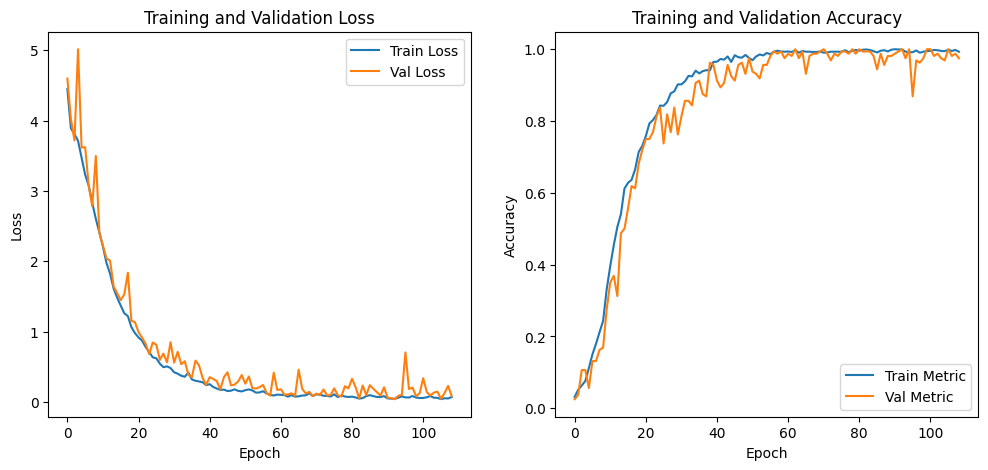

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Metric")
plt.plot(val_accs, label="Val Metric")
plt.xlabel("Epoch")
plt.ylabel(
    "Accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "RMSE"
)
plt.legend()
plt.title(
    f"Training and Validation {'Accuracy' if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks] else 'RMSE'}"
)

plt.show()

In [9]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_metric_loaded = checkpoint.get("val_metric")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_metric={val_metric_loaded}, val_loss={val_loss_loaded})"
)

test_results = evaluate_model(
    model,
    test_loader,
    device,
    TASK,
    criterion=criterion if TASK not in [Task.multi_tasks] else None,
    criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
    criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
    num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
    num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
    multi_label=multi_label,
    multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
)

test_metric = test_results.get("accuracy", test_results.get("rmse", 0.0))
test_rmse = test_results.get("rmse", 0.0)
accuracy_p = test_results.get("accuracy_p", 0.0)
accuracy_r = test_results.get("accuracy_r", 0.0)

if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
    print(f"Test Set Accuracy: {test_metric:.4f}")
    if TASK == Task.pose_multi:
        print(f"Test Set P Accuracy: {accuracy_p:.4f}")
        print(f"Test Set R Accuracy: {accuracy_r:.4f}")
    if TASK == Task.multi_tasks:
        print(f"Test Set RMSE: {test_rmse:.4f}")
        if multi_label:
            print(f"Test Set P Accuracy: {accuracy_p:.4f}")
            print(f"Test Set R Accuracy: {accuracy_r:.4f}")
else:
    print(f"Test Set RMSE: {test_metric:.4f}")

Loaded checkpoint from ../model/resnet50_multi_tasks_augmented.pth (epoch=93, val_metric=1.0, val_loss=0.042379673570394516)
Test Set Accuracy: 1.0000
Test Set RMSE: 0.0514


In [10]:
results = {
    "model_name": MODEL_NAME,
    "metric_name": "accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "rmse",
    "metric_value": test_metric,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
        "multi_label": multi_label,
        "multi_tasks_regression_loss_weight": MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    },
}

if TASK == Task.pose_single or (TASK == Task.multi_tasks and not multi_label):
    results["metadata"]["precision"] = test_results.get("precision", 0.0)
    results["metadata"]["recall"] = test_results.get("recall", 0.0)
    results["metadata"]["f1"] = test_results.get("f1", 0.0)

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    results["metadata"]["accuracy_p"] = accuracy_p
    results["metadata"]["accuracy_r"] = accuracy_r
    results["metadata"]["precision_p"] = test_results.get("precision_p", 0.0)
    results["metadata"]["recall_p"] = test_results.get("recall_p", 0.0)
    results["metadata"]["f1_p"] = test_results.get("f1_p", 0.0)
    results["metadata"]["precision_r"] = test_results.get("precision_r", 0.0)
    results["metadata"]["recall_r"] = test_results.get("recall_r", 0.0)
    results["metadata"]["f1_r"] = test_results.get("f1_r", 0.0)

if TASK == Task.multi_tasks:
    results["metadata"]["rmse"] = test_rmse

out_dir = f"../eval/{TASK}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to ../eval/multi_tasks/resnet50_multi_tasks_augmented.json
